In [15]:
import numpy as np
import scipy.integrate as integrate
import random
import scipy.stats as stats

import math
import pandas as pd
import csv
import matplotlib.pyplot as plt

# Notation we use below.
arctan = np.arctan
cos = np.cos
det = np.linalg.det
exp = np.exp
inner = np.inner
log = np.log
matmul = np.matmul
norm = np.linalg.norm
odeint = integrate.odeint
pi = np.pi
quad = integrate.quad
randbinom = np.random.binomial
randexp = np.random.exponential
randnorm = np.random.normal
randperm = np.random.permutation
randuni = np.random.uniform
sin = np.sin
sqrt = np.sqrt

In [16]:
# access csv files, change file name as necessary
casesData = pd.read_csv('CDC052322.csv', skiprows=(0,1))
varData = pd.read_csv('CovidPropsJ.csv')

# specify columns, convert to numpy
dates = pd.DataFrame(casesData, columns=['Date'])
avgCases = pd.DataFrame(casesData, columns=['7-Day Moving Avg'])
dates = pd.DataFrame.to_numpy(dates, dtype=str)
avgCases = pd.DataFrame.to_numpy(avgCases, dtype=int)

percentDelta = pd.DataFrame(varData, columns=['perc_deltas'])
percentOmicron = pd.DataFrame(varData, columns=['perc_omicrons'])
percentDelta = pd.DataFrame.to_numpy(percentDelta, dtype=float)
percentOmicron = pd.DataFrame.to_numpy(percentOmicron, dtype=float)

# preallocate empty lists for biweekly dates and cases
biweeklyDates = []
biweeklyCases = []
n = None

#fill in biweekly dates/cases based on starting date (Jan 11 2021)
for i in range(len(dates[:,0])):
    j = len(dates[:,0]) - 1 - i
    if dates[j,0] == 'Jan 11 2021':
        biweeklyDates.append(dates[j,0])
        biweeklyCases.append(avgCases[j,0])
        n = j
        break

for i in range(34):
    n = n - 14
    biweeklyDates.append(dates[n,0])
    biweeklyCases.append(avgCases[n,0])


numDelta = []
numOmicron = []
for i in range(len(biweeklyDates)):
    delta = percentDelta[i,0]*biweeklyCases[i]
    numDelta.append(delta)
    omicron = percentOmicron[i,0]*biweeklyCases[i]
    numOmicron.append(omicron)
    


finalTable = [['Dates', '# of Delta', '# of Omicron', '# of Total Cases']]
for i in range(len(biweeklyDates)):
    finalTable.append([biweeklyDates[i], numDelta[i], numOmicron[i], biweeklyCases[i]])

In [17]:
N = 329000000
propDelta = [numDelta[i]/N for i in range(len(numDelta))]
propDelta
propOmicron = [numOmicron[i]/N for i in range(len(numOmicron))]

In [18]:
len(finalTable) # 36 time points

36

Text(0, 0.5, 'Prop of Population Infected')

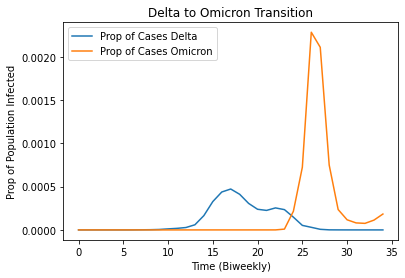

In [19]:
fig, ax = plt.subplots()
ax.plot(propDelta, label='Prop of Cases Delta')
ax.plot(propOmicron, label='Prop of Cases Omicron')
legend = ax.legend(loc='upper left')
plt.title('Delta to Omicron Transition')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Population Infected')       

In [20]:
# SIR Ordinary Differential Equation
def V(x,t,beta,gamma):
    return [-beta*x[0]*x[1], beta*x[0]*x[1]-gamma*x[1], gamma*x[1]] # [s(t), i(t), r(t)]

In [54]:
# Fitting a range of different beta values. Play around with this!

beta_grid = np.linspace(start=.1, stop=2, num=20)
print(beta_grid)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]


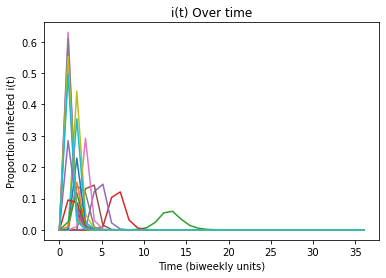

In [61]:
# Population size
N = 329000000

# fix gamma (5 day recovery)
gamma = 0.2

for beta in beta_grid: 
    
    # Initial condition; i_0 is the initial number of infected people
    i_0 = 1/N
    x = [1-i_0, i_0, 0]

    # Time
    days = 36*14
    steps = 36
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; phi is the solution phi=[s(t), i(t), r(t)]
    phi = odeint(V, x, T, args=(beta,gamma)) 

    # s compartment
    s = phi[:,0]
    # i compartment
    i = phi[:,1]
    # r compartment
    r = phi[:,2]
    
    
    # Plots of the solved differential equations
    plt.plot(T/14,i,label="i")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected i(t)')
    plt.title('i(t) Over time')

Although the shape of the Omicron curve is very similar to an approximat [beta, gamma] = [0.4, 0.2] (with r0 = 2) the proportion truly infected in the data is quite low.

### Logistic Growth Model
#### DOES THE PROPORTION OF A MORE VIRULENT STRAIN FIT A LOGISTIC GROWTH CURVE?

In [24]:
def L(x,t,beta,gamma):
    # LOGISTIC GROWTH Differential Equation
    return [-beta*x[0]*x[1], x[1]*(1-x[1])*beta*1] # [ignore, i_2_prop]

In [40]:
# Figuring out Time Units on X axis
days = 14*36 # two weeks * 36 
steps = 14 # plot a point every 2 weeks
T = np.linspace(0,days,steps)
print(T) # in days
print(T/14) # in biweekly timeunits.

[  0.          38.76923077  77.53846154 116.30769231 155.07692308
 193.84615385 232.61538462 271.38461538 310.15384615 348.92307692
 387.69230769 426.46153846 465.23076923 504.        ]
[ 0.          2.76923077  5.53846154  8.30769231 11.07692308 13.84615385
 16.61538462 19.38461538 22.15384615 24.92307692 27.69230769 30.46153846
 33.23076923 36.        ]


In [42]:
# Play around with this grid of values.
diff_beta_grid = np.linspace(start=.1, stop=.2, num=10)
diff_beta_grid

array([0.1       , 0.11111111, 0.12222222, 0.13333333, 0.14444444,
       0.15555556, 0.16666667, 0.17777778, 0.18888889, 0.2       ])

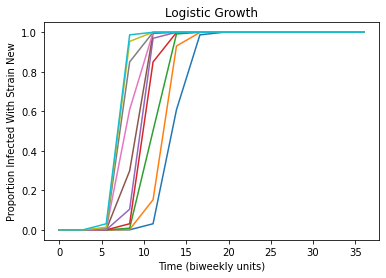

In [62]:
# Population size of USA
N = 329000000

for diff_beta in diff_beta_grid: 
    
    # proportions of i_1 and i_2
    prop_i_2 = 1/N # initial proportion of variant 2: i_2/(i_2+i_1)
    x = [1-prop_i_2, prop_i_2] # (i_1/(i_2+i_1), i_2/(i_2+i_1))

    # Time
    days = 600
    steps = days
    T = np.linspace(0,days,steps)
    
    # Time units
    days = 14*36 # two weeks * 36 
    steps = 14 # every 2 weeks
    T = np.linspace(0,days,steps)

    # Integrate (aka solve) the ODE; the logistic_vector is the solution.
    logistic_vector = odeint(L, x, T, args=(diff_beta,gamma)) 

    i_logistic_curve = logistic_vector[:,1]

    # plot
    plt.plot(T/14,i_logistic_curve,label="Logistic Growth")
    plt.xlabel('Time (biweekly units)')
    plt.ylabel('Proportion Infected With Strain New')
    plt.title('Logistic Growth')

Text(0, 0.5, 'Prop of Cases Omicron')

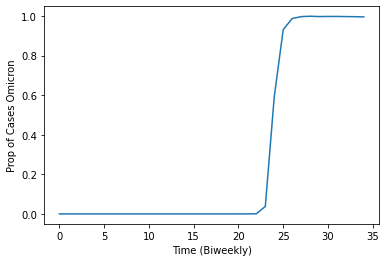

In [29]:
# Data From True Omicron Props.
fig, ax = plt.subplots()
ax.plot(percentOmicron, label='Prop of Cases Omicron')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases Omicron')  

Text(0, 0.5, 'Prop of Cases Delta')

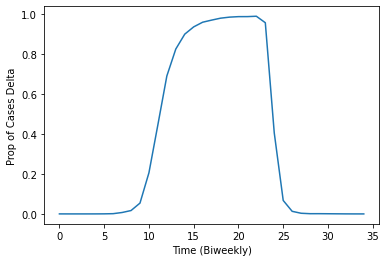

In [44]:
# Data From True Delta Props.
fig, ax = plt.subplots()
ax.plot(percentDelta, label='Prop of Cases Omicron')
plt.xlabel('Time (Biweekly)')
plt.ylabel('Prop of Cases Delta')  